<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ensemble-Learning-and-Random-Forests" data-toc-modified-id="Ensemble-Learning-and-Random-Forests-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Ensemble Learning and Random Forests</a></span><ul class="toc-item"><li><span><a href="#Voting" data-toc-modified-id="Voting-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Voting</a></span></li><li><span><a href="#Bagging-and-Pasting" data-toc-modified-id="Bagging-and-Pasting-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Bagging and Pasting</a></span></li><li><span><a href="#Out-of-Bag-Evaluation" data-toc-modified-id="Out-of-Bag-Evaluation-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Out-of-Bag Evaluation</a></span></li><li><span><a href="#Random-Patches-and-Random-Subspaces" data-toc-modified-id="Random-Patches-and-Random-Subspaces-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Random Patches and Random Subspaces</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-8.6"><span class="toc-item-num">8.6&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-8.7"><span class="toc-item-num">8.7&nbsp;&nbsp;</span>Boosting</a></span><ul class="toc-item"><li><span><a href="#AdaBoost(Adaptive-Boosting)" data-toc-modified-id="AdaBoost(Adaptive-Boosting)-8.7.1"><span class="toc-item-num">8.7.1&nbsp;&nbsp;</span>AdaBoost(Adaptive Boosting)</a></span></li><li><span><a href="#Grandient-Boosting" data-toc-modified-id="Grandient-Boosting-8.7.2"><span class="toc-item-num">8.7.2&nbsp;&nbsp;</span>Grandient Boosting</a></span></li></ul></li><li><span><a href="#Stacking" data-toc-modified-id="Stacking-8.8"><span class="toc-item-num">8.8&nbsp;&nbsp;</span>Stacking</a></span></li></ul></li></ul></div>

# Ensemble Learning and Random Forests
* A group of predictors is called an *ensemble*
* Ensemble methods work best when the predictors are as independent from one another as possible

In [42]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

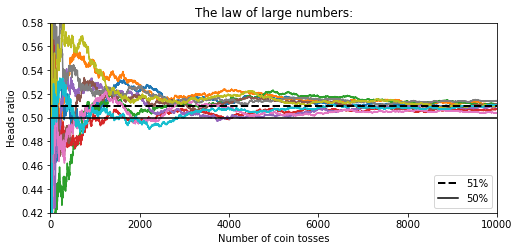

In [43]:
# Suppose you have a slightly biased coin that has a 51% chance of coming up heads/49% chance of coming up tails.
# the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads(51%)
heads_proba = 0.51
coin_tosses = (rnd.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(
    coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
#cumulative_heads_ratio

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.title("The law of large numbers:")
plt.axis([0, 10000, 0.42, 0.58])
#save_fig("law_of_large_numbers_plot")
plt.show()

## Voting
* Hard voting: aggregate the predictions of each classifier and predict the class that gets the most votes.
* even if each classifier is a weak learning(slightly better than random guessing), the ensemble can still be a strong learner(achieving high accuracy).
* Soft voting: If all classifier can estimate class probability(predict_proba() method), then Scikit-Learn can predict the class with the highest class probability, averaged over all individual classifiers.
* Soft voting often achieves higher performance than hard voting because it gives more weight to highly confident votes.

In [44]:
# build a voting classifier in Scikit using three weaker classifiers

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# use moons dataset
X, y = make_moons(
    n_samples=500, 
    noise=0.30, 
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# voting classifier = logistic + random forest + SVC

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft'
    )
voting_clf.fit(X_train, y_train)

# let's see how each individual classifier did:

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# voting classifier did better than 3 individual ones!

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting
* Use the same training algorithm for every predictor and train them on different random subsets of the training set.
* Bagging(bootstrap aggregating): sampling the dataset **with** replacement.
* Pasting: sampling the dataset **without** replacement.
* Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
* for classifier: aggregation - statistical mode(most frequent prediction, just like a hard voting classifier)
* for regression: aggregation - the average
* Each individual predictor has a higher bias than if it were trained on the original training set.
* Aggregation reduces both bias and variance.
* Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained -> bagging ends up with a slightly higher bias than pasting -> extra diversity also means that the predictors end up being less correlated -> the ensemble variance is reduced.

In [45]:
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Train ensemble of 500 Decision Tree classifiers
# each using 100 training instances - randomly sampled from training set
# with replacement.

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500,
        max_samples=100, 
        bootstrap=True, # set to False for pasting instead of bagging.
        n_jobs=-1, 
        random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [46]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [47]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    

<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)


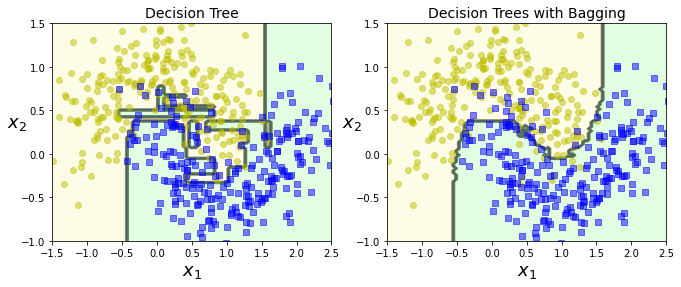

In [48]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

#the ensemble's predictions will likely generalise much better than the single Decision Tree's prediction
#the ensemble has a comparable bias but a smaller variance
#it makes roughly the same number of errors on the training set, but the decision boundary is less irregular.

## Out-of-Bag Evaluation
* Bagging - some instance may be sampled multiple times, others not at all.
* about 63% of the training instances are sampled on average traninig set. The remaining 37% of the taining instances that are not sapled are called *out-of-bag(oob)* instances.
* since predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set.
* by oob_score=True

In [49]:
# oob_score_: predicts classifier results on test set.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [50]:
# did oob_score_ do a good job?
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.888

In [51]:
# oob decision functionfor each training instance
bag_clf.oob_decision_function_

array([[0.37430168, 0.62569832],
       [0.42424242, 0.57575758],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06951872, 0.93048128],
       [0.33939394, 0.66060606],
       [0.01142857, 0.98857143],
       [1.        , 0.        ],
       [0.97619048, 0.02380952],
       [0.78333333, 0.21666667],
       [0.01724138, 0.98275862],
       [0.81564246, 0.18435754],
       [0.81967213, 0.18032787],
       [0.95263158, 0.04736842],
       [0.03680982, 0.96319018],
       [0.00543478, 0.99456522],
       [0.96923077, 0.03076923],
       [0.93714286, 0.06285714],
       [0.98333333, 0.01666667],
       [0.035     , 0.965     ],
       [0.34042553, 0.65957447],
       [0.91005291, 0.08994709],
       [1.        , 0.        ],
       [0.95108696, 0.04891304],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.69942197, 0.30057803],
       [0.

## Random Patches and Random Subspaces
* BaggingClassifier class supports sampling the features
* Useful when dealing with high-dimensional inputs(such as images)
* sample is controlled by two hyperparameters: max_features and bootstrap_features
* Random Patches: sampling both training instances and features 
* Random Subspaces: Keeping all instances(bootstrap=False and max_samples=1.0), but sampling features(bootstrap_features=True and/or max_features <1.0)

## Random Forests
* Ensemble of Decision trees
* instead of searching for the very best feature when splitting a node, it searches for the best featur among a random subset of features.
* the algorithm results in greater tree diversity, which trades a higher bias for a lower variance -> generally yielding an overall better model
* RandomForestClassifier is designed for Decision Tree classification
* RandomForestsRegressor is designed for regression

In [52]:
# Using Decision Trees with Bagging
# Train an RF classifier with 500 trees limited to 16 max nodes each.
# splitter="random": tells RF to search for best feature among
# a random subset of features.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter="random", 
        max_leaf_nodes=16, 
        random_state=42),

    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True,
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [53]:
# Using RandomeForestClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [54]:
# almost identical predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

## Feature Importance
* Scikit-Learn measures a feature's importance by looking *how much the tree nodes that use that feature reduce impurity on average*(across all trees in the forest).
* important features likely to appear closer to root of tree
* unimportant features likely to appear closer to leaves - if at all.

In [55]:
# rank features by importance in iris
# #1: petal length: 44%

from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(iris["data"], iris["target"])

for name, importance in zip(
    iris["feature_names"], 
    rnd_clf.feature_importances_):
        print(name, "=", importance)


sepal length (cm) = 0.11249225099876375
sepal width (cm) = 0.02311928828251033
petal length (cm) = 0.4410304643639577
petal width (cm) = 0.4233579963547682


In [56]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by con

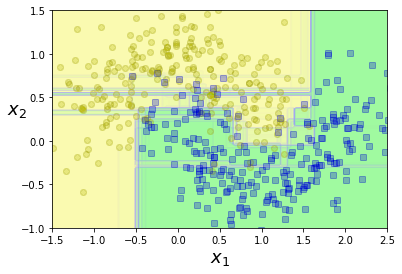

In [57]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(
        max_leaf_nodes=16, 
        random_state=42+i)

    indices_with_replacement = rnd.randint(
        0, 
        len(X_train), 
        len(X_train))

    tree_clf.fit(
        X[indices_with_replacement], 
        y[indices_with_replacement])

    plot_decision_boundary(
        tree_clf, X, y, 
        axes=[-1.5, 2.5, -1, 1.5], 
        alpha=0.02, 
        contour=False)

plt.show()

## Boosting
* Boosting refers to any Ensemble method that can combine several weak learners into a strong learner
* The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.
### AdaBoost(Adaptive Boosting)
* to pay more attention to the training instances that the predecessor underfitted - focusing more and more on the hard cases
* The more accurate the predictor is, the higher its weight will be.
* if it is just guessing randomly, then its weight is close to 0.
* if it is most often wrong, then its weights will be negative.
* Disadvantage: results depend on previous classifier(sequential), so algorithm can not be parralelised (not good for scaling).

<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-58-ac50674da6ce>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot)
<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-58-ac50674da6ce>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, t

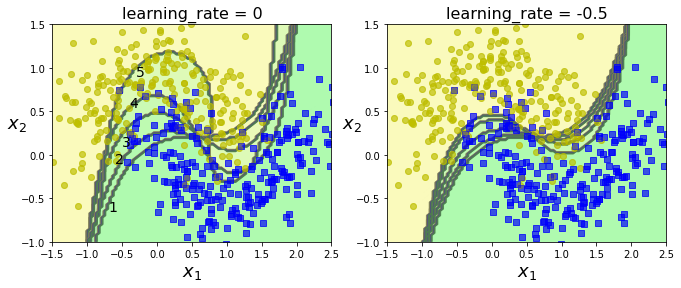

In [58]:
# Plot decision boundaries of five predictors on moons dataset

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)

        svm_clf = SVC(
            kernel="rbf", 
            C=0.05)

        svm_clf.fit(
            X_train, y_train, 
            sample_weight=sample_weights)

        y_pred = svm_clf.predict(
            X_train)

        sample_weights[y_pred != y_train] *= (1 + learning_rate)

        plot_decision_boundary(
            svm_clf, 
            X, y, 
            alpha=0.2)

        plt.title("learning_rate = {}".format(learning_rate - 1), 
                  fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
#save_fig("boosting_plot")
plt.show()

# left: 1st clf gets many wrong, so 2nd clf gets boosted values.
# right: same sequence, but learning rate cut in half (The misclassified instance weights are boosted half as much at every iteration)
# similart with Gradient Descent, instead of tweaking a single predictor's parameters to minimise a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

<ipython-input-47-45a2f64510a2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)


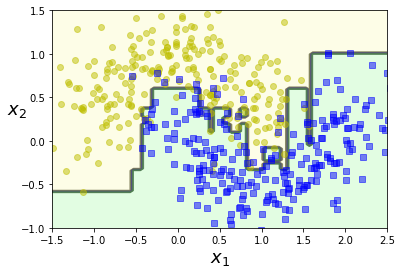

In [59]:
# train AdaBoost classifier on 200 decision stumps (DS)
# DS = decision tree with max_depth=1

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.5, random_state=42
    )
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)
plt.show()

### Grandient Boosting
* works by sequentially adding predictors to an ensemble, each one correcting its predecessor (just like AdaBoost)
* fit the new predictor to the *residual errors* made by the previous predictor insteand of tweaking the instance weights at every iteration(AdaBoost)
* Gradient Tree Boosting pr Gradient Boosted Regression Trees(GBRT)

In [60]:
from sklearn.tree import DecisionTreeRegressor

# training set: a noisy quadratic function
rnd.seed(42)
X = rnd.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * rnd.randn(100)

# train Regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# now train 2nd Regressor using errors made by 1st one.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# now train 3rd Regressor using errors made by 2nd one.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

# now have ensemble w/ three trees.
y_pred = sum(tree.predict(X_new) for tree in (
    tree_reg1, tree_reg2, tree_reg3))

print(y_pred)

[0.75026781]


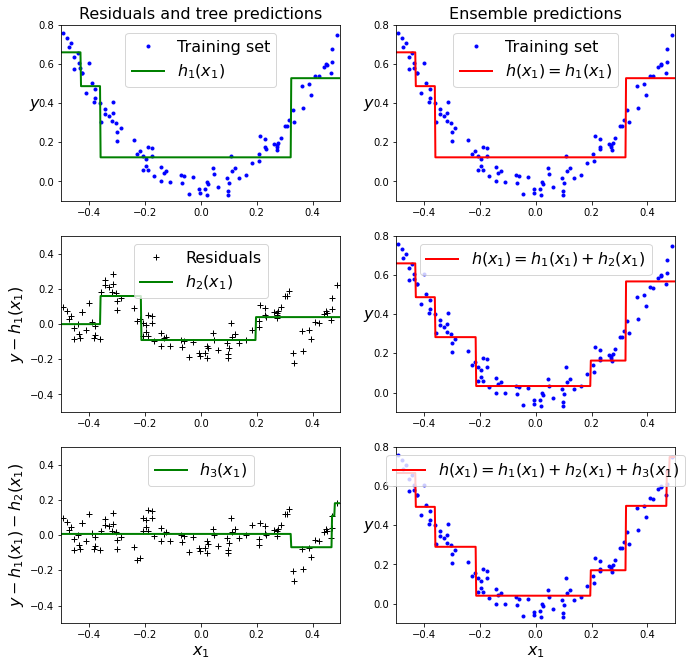

In [61]:
def plot_predictions(
    regressors, X, y, axes, 
    label=None, 
    style="r-", 
    data_style="b.", 
    data_label=None):

    x1 = np.linspace(axes[0], axes[1], 500)

    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)

    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

# 1st row: ensemble = only one tree: predictions match 1st tree.
# 2nd row: new tree trained on residual errors of 1st tree.
# 3rd row: "                                              "
# result: ensemble predictions get better as trees are added.

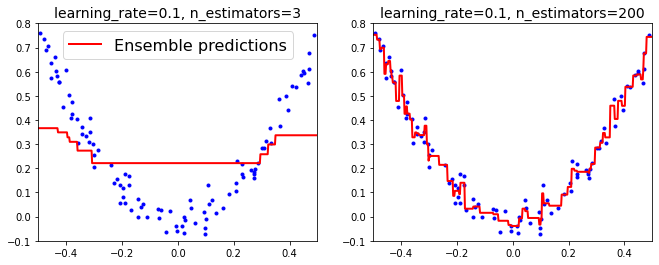

In [62]:
# two GBRT ensembles trained with low learning rate
# Shrinkage: If you set the learning rate very low(such as 0.1), you will need more trees in the ensemble to fit the training set, but the predictions will usually genearalise better.

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=0.1, 
    random_state=42)

gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42)

gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions(
    [gbrt], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8], 
    label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions(
    [gbrt_slow], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

# left: not enough trees (underfits)
# right: too many trees (overfits)
# to find optimal number of trees: use early stopping method

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

# train GRBR regressor with 120 trees

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=120, 
    learning_rate=0.1, 
    random_state=42)

gbrt.fit(X_train, y_train)

# measure MSE validation error at each stage
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]


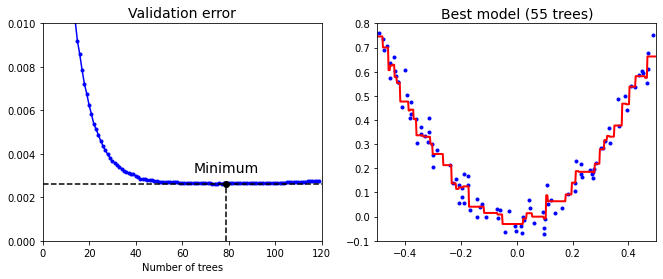

In [64]:
# train another GBRT ensemble using optimal #trees

best_n_estimators = np.argmin(errors)
min_error = errors[best_n_estimators]

gbrt_best = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=best_n_estimators, 
    learning_rate=0.1, 
    random_state=42)

gbrt_best.fit(X_train, y_train)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=79,
             random_state=42, subsample=1.0, verbose=0, warm_start=False)
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (55 trees)", fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

* possible to implement early stopping by actually stopping training early
* via warm_start=True(keep exising trees when the fit() method is called, allowing incremental training)

In [65]:
gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=1, 
    learning_rate=0.1, 
    random_state=42, 
    warm_start=True)

min_val_error = float("inf")
error_going_up = 0

# 120 estimators.
# stop training with validation error doesn't improve for
# five consecutive iterations

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)

59


## Stacking
* instead of using trivial functions(such as hard voting) to aggregate the predictions of all predictors in an ensemble, train a model to perform this aggregation(blending)
* final predictor: *blender* or a *meta learner*
* to train the blender, a common approach is to use a hold-out set.